# Winter sea ice growth: sea ice thickness & type

This notebook plots change in ice thickness and change in ice type to get a better clearer picture of the dynamics of sea ice growth and differences between winter 2018-19 and 2019-20.
 
 
**Input**:
 - NETCDF4 file from the jupyter book's google bucket
 
 
 **Output**: 
  - Plots of sea ice thickness and sea ice type in the Arctic

```{note}
Try running this notebook in Google Colab! Toggle over the rocketship icon at the top of the page and click Colab to open a new window and run the notebook. <br><br>To run a single cell, type **Shift+Enter** or under **Runtime** click **Run all**. Note that you will have to run the notebook from the very beginning and load all the Google Colab dependencies for the code to work.
```

In [1]:
#this cell will load dependencies for running the notebook in Google Colab
#this cell may take a while to run
import sys

#if code is running in google colab, run these cells to install neccessary libraries
if 'google.colab' in sys.modules: 
    !apt-get install -qq libgdal-dev libproj-dev
    !pip install --no-binary shapely shapely --force
    !pip install -q pyproj
    !pip install cartopy
    !pip install netcdf4
    !pip install xarray==0.16.0 

## Import notebook dependencies

In [2]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import scipy.interpolate
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
from datetime import date
import matplotlib.pyplot as plt
import numpy.ma as ma

#axes needed for plotting
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

# Ignore warnings in the notebook to improve display
# You might want to remove this when debugging/writing new code
import warnings
warnings.filterwarnings('ignore')
 
#increase resolution for notebook outputs
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' 

#import utils function from google bucket 
!gsutil cp gs://icesat2-book-data/utils.py ./
import utils

Copying gs://icesat2-book-data/utils.py...
/ [1 files][ 14.5 KiB/ 14.5 KiB]                                                
Operation completed over 1 objects/14.5 KiB.                                     


## Load data into notebook
Copy file from the book's google bucket and load into an xarray dataset. 

In [3]:
!gsutil -m cp gs://icesat2-book-data/icesat2-book-dataset.nc ./
dataset = xr.open_dataset('icesat2-book-dataset.nc')

Copying gs://icesat2-book-data/icesat2-book-dataset.nc...
/ [1/1 files][138.4 MiB/138.4 MiB] 100% Done                                    
Operation completed over 1 objects/138.4 MiB.                                    


## Restrict dataset to region of interest

In [4]:
#define a list of keys corresponding to the region of interest
regionKeyList = [10,11,12,13,15] #Inner Arctic

#restrict data to that region
dataset = utils.restrictRegionally(dataset, regionKeyList)

Regions selected: Inner Arctic


## Calculate and plot mean monthly data
Add mean monthly data as coordinates to the dataset and plot the data for two winters.

### Calculate mean monthly values and add to dataset
Define a function to calculate mean monthly uncertainity and mean monthly ice thicknesses for all ice types combined, multi year ice, and first year ice, and add data as coordinates to the dataset. Then, call the function to update the dataset.

In [5]:
def calcMeans(dataset): 
    """Calculates mean monthly uncertainity and mean monthly ice thicknesses for all ice types combined, multi year ice, and first year ice, and adds data as coordinates to the dataset.
    
    Args: 
        dataset (xr Dataset): dataset generated by Load_IS2 notebook
    
    Returns: 
        datasetMeans (xr Dataset): dataset with means added as data variables to the input dataset
    """  
    #calculate mean uncertainites 
    meanUnc = dataset['ice_thickness_unc_filled'].mean(dim = ['x','y'], skipna = True)
    meanUnc.attrs = {'description': 'mean monthly ice thickness uncertainty', 'units': 'meters'}
    
    #calculate mean thickness for all ice types
    meanThickness = dataset['ice_thickness_filled'].mean(dim = ['x','y'], skipna = True)
    meanThickness.attrs = {'description': 'mean monthly ice thickness for all ice types', 'units': 'meters'}
    
    #calculate mean thickness for multi year ice
    MYIThickness = dataset['ice_thickness_filled'].where(dataset['ice_type_filled'] == 1)
    meanMYIThickness = MYIThickness.mean(dim = ['x','y'], skipna = True)
    meanMYIThickness.attrs = {'description': 'mean monthly multi year ice thickness', 'units': 'meters'}
    
    #calculate mean thickness for first year ice 
    FYIThickness = dataset['ice_thickness_filled'].where(dataset['ice_type_filled'] == 0)
    meanFYIThickness = FYIThickness.mean(dim = ['x','y'], skipna = True)
    meanFYIThickness.attrs = {'description': 'mean monthly first year ice thickness', 'units': 'meters'}
    
    #add means as coordinates to dataset
    datasetMeans = dataset.assign_coords(coords = {'mean_ice_thickness_unc': meanUnc, 'mean_ice_thickness': meanThickness, 
                'mean_MYI_thickness': meanMYIThickness, 'mean_FYI_thickness': meanFYIThickness})
    
    return datasetMeans

Call function to update dataset

In [6]:
dataset = calcMeans(dataset)

### Plot mean monthly ice thickness for two winter seasons 
Produce a figure that shows mean monthly ice thickness and associated mean monthly uncertainities for two winter seasons.
 - Choose a start year, defined <span style="color:darkmagenta; font-family: Courier">yearStart</span>, and the function will plot data from that winter and the next 
     - i.e. setting <span style="color:darkmagenta; font-family: Courier">yearStart = 2018</span> would plot data for winter 18-19 and winter 19-20

In [7]:
def plotThicknessCompare(dataset, yearStart = 2018, regionsText = None):
    """ Plots mean monthly ice thickness for two winter seasons. 
    
    Args: 
        dataset (xr Dataset): dataset generated by Load_IS2 notebook
        yearStart (int): year to start plot at (default to 2018)
        regionsText(str, optional): string describing regions containing data, if user wants to define the region themself (default to None)
        title (str, optional): title string to add to plot 
        ylim (list, optional): list containing [min value, max value] for limits of y axis for plotting ice thickness (defaults to matplotlib generated limits)
        ylimFrac (list, optional): list containing [min value, max value] for limits of y axis for plotting MYI fraction (defaults to matplotlib generated limits)

    Returns: 
        Figure displayed in notebook 
     
    Restrictions: 
        dataset input needs to contain the following coordinates: mean_ice_thickness_unc, mean_ice_thickness, mean_MYI_thickness, mean_FYI_thickness 
    """
        
    #initialize figure
    fig = plt.figure()
    ax = plt.axes([0, 0, 1, 1]) 
    title = plt.title('Mean Monthly Ice Thickness & Uncertainty', y = 1.11, x = 0.5, fontsize = 'x-large', horizontalalignment = 'center')
    gridlines = plt.grid(b = True, linestyle = '--', alpha = 0.4) #add gridlines 
    
    #add title describing regions with data 
    if 'regions with data' in list(dataset.attrs.keys()): 
        regionsText = dataset.attrs['regions with data']
        regionsTitle = ax.text(x = 0.5, y = 1.05, s = 'Region/s: ' + regionsText, size = 12, transform=ax.transAxes, fontsize = 'large', horizontalalignment = 'center')

    #get list of months for plotting x axis 
    winterMonths = list(pd.to_datetime(utils.getWinterDateRange(2018, 2019)).strftime('%B'))

    #plot data for winter 1
    datasetWinter1 = dataset.sel(time = utils.getWinterDateRange(yearStart, yearStart + 1))
    winter1Str = 'Winter ' + str(yearStart)[2:4] + '-' + str(yearStart + 1)[2:4]
    color1 = 'royalblue'
    ax.plot(winterMonths, datasetWinter1['mean_ice_thickness'].values, color = color1, linestyle = '--', marker = 'o', label = winter1Str + ' ice thickness')
    ax.fill_between(winterMonths, datasetWinter1['mean_ice_thickness'].values - datasetWinter1['mean_ice_thickness_unc'].values, datasetWinter1['mean_ice_thickness'].values + datasetWinter1['mean_ice_thickness_unc'].values, facecolor = color1, alpha = 0.1, edgecolor = 'none', label = winter1Str + ' uncertainty')
    #ax.errorbar(winterMonths, datasetWinter1['mean_ice_thickness'].values, yerr = datasetWinter1['mean_ice_thickness_unc'].values, color = color1, alpha = 0.7, capsize = 3, zorder = 2, label = winter1Str)        
    
    #plot data for winter 2
    datasetWinter2 = dataset.sel(time = utils.getWinterDateRange(yearStart + 1, yearStart + 2))
    winter2Str = 'Winter ' + str(yearStart + 1)[2:4] + '-' + str(yearStart + 2)[2:4]
    color2 = 'darkgoldenrod'
    ax.plot(winterMonths, datasetWinter2['mean_ice_thickness'].values, color = color2, linestyle = '-', marker = 's', label = winter2Str + ' ice thickness')
    ax.fill_between(winterMonths, datasetWinter2['mean_ice_thickness'].values - datasetWinter2['mean_ice_thickness_unc'].values, datasetWinter2['mean_ice_thickness'].values + datasetWinter2['mean_ice_thickness_unc'].values, facecolor = color2, alpha = 0.1, edgecolor = 'none', label = winter2Str + ' uncertainty')
    #ax.errorbar(winterMonths, datasetWinter2['mean_ice_thickness'].values, yerr = datasetWinter2['mean_ice_thickness_unc'].values, color = color2, alpha = 0.7, capsize = 3, zorder = 2, label = winter2Str)        
    
    #add legend & labels
    ax.legend(loc = 'best', fontsize = 10)
    ax.set_ylabel('Mean monthly ice thickness & uncertainty (m)')
    ax.set_xlabel('Month')
 
    plt.show()

Call function to plot data.

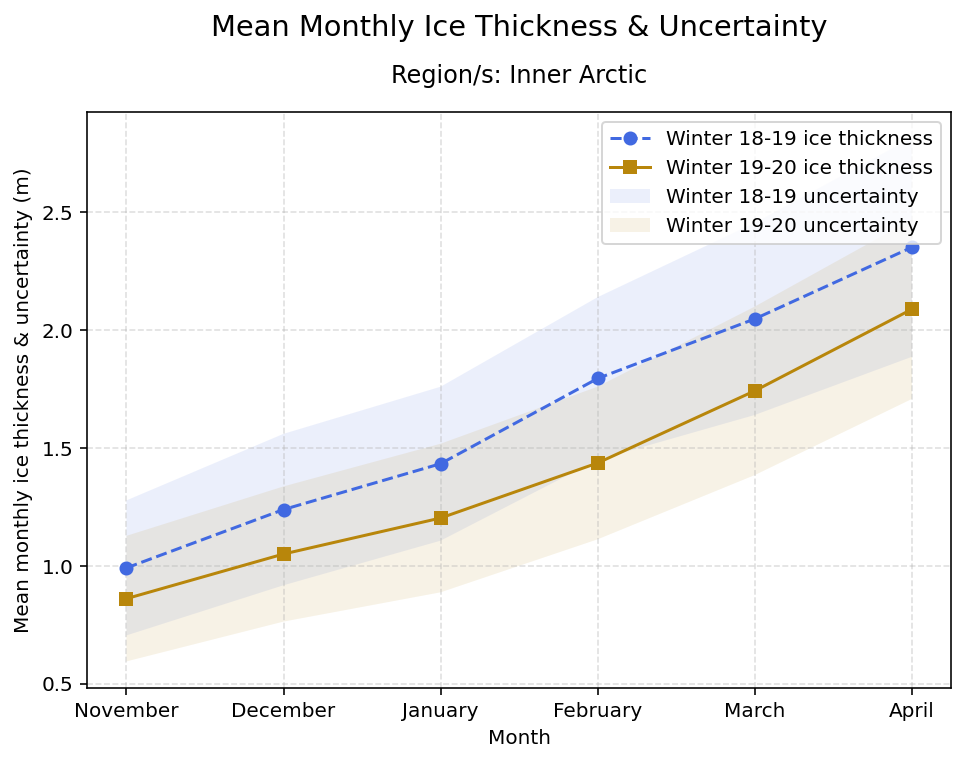

In [8]:
plotThicknessCompare(dataset, yearStart = 2018, regionsText = 'Inner Arctic')

## Sea ice type
Now we want to know the percentage of each ice type (multi year vs. first year ice) in the region/s of interest, and add to our dataset. We will define a function that generates a plot to visualize the data. 

### Calculate percent ice type and add to dataset 
Function calculates monthly percent multi year ice and first year ice in the dataset.

In [9]:
def calcPercentType(dataset): 
    """Calculates percent ice type and adds to dataset.
    
    Args: 
        dataset (xr Dataset): dataset generated by Load_IS2 notebook
    
    Returns: 
        datasetFracIceType (xr Dataset): dataset with percent ice types added as data variables to the input dataset
    """  
    #calculate percent multi year ice
    MYI = dataset.where(dataset['ice_type_filled'] == 1, drop = True)
    fracMYI = (MYI['ice_thickness_filled'].count(dim = ['x','y']) / dataset['ice_thickness_filled'].count(dim = ['x','y']))
    percentMYI = fracMYI*100
    percentMYI.attrs = {'description': 'percent multi year ice in dataset', 'units': '(0-100)%'}

    #calculate percent first year ice
    FYI = dataset.where(dataset['ice_type_filled'] == 0, drop = True)
    fracFYI = (FYI['ice_thickness_filled'].count(dim = ['x','y']) / dataset['ice_thickness_filled'].count(dim = ['x','y']))
    percentFYI = fracFYI*100
    percentFYI.attrs = {'description': 'percent first year ice in dataset', 'units': '(0-100)%'}

    #add percentages as coordinates to new dataset
    datasetFracIceType = dataset.assign_coords(coords = {'percent_MYI': percentMYI, 'percent_FYI': percentFYI})
    
    return datasetFracIceType

Call function to update dataset

In [10]:
dataset = calcPercentType(dataset)

### Plot ice thickness means and percent multi year ice 
Define a function to plot multi year, first year, and total mean monthly ice thickness, along with percent multi year ice on twin axes.

In [11]:
def plotThicknessAndFrac(dataset, title = None, ylim = None, ylimFrac = None):
    """ Plots multi year, first year, and total mean monthly ice thickness, along with percent multi year ice on twin axes. 
    
    Args: 
        dataset (xr Dataset): dataset generated by Load_IS2 notebook
        title (str, optional): title string to add to plot 
        ylim (list, optional): list containing [min value, max value] for limits of y axis for plotting ice thickness (defaults to matplotlib generated limits)
        ylimFrac (list, optional): list containing [min value, max value] for limits of y axis for plotting ice thickness (defaults to matplotlib generated limits)

    Returns: 
        Figure displayed in notebook 
    
    Restrictions: 
        dataset input needs to contain the following coordinates: mean_ice_thickness, mean_MYI_thickness, mean_FYI_thickness, percent_MYI, percent_FYI
    """
    
    #initialize figure
    fig = plt.figure()
    if title != None: 
        inputTitle = plt.title(title, y = 1.3, x = 0.45, fontsize = 'x-large', horizontalalignment = 'center')
    ax = plt.axes([0, 0, 1, 1]) 
    gridlines = plt.grid(b = True, linestyle = '--', alpha = 0.4) #add gridlines
    if ylim == None: 
        ax.set_ylim([min(datasetWinter['mean_FYI_thickness'].values) - 0.2, max(datasetWinter['mean_MYI_thickness'].values) + 0.2])
    else: 
        ax.set_ylim(ylim)
    
    #add title describing regions with data 
    if 'regions with data' in list(dataset.attrs.keys()): 
        regionsText = dataset.attrs['regions with data']
        regionsTitle = ax.text(x = 0.5, y = 1.05, s = 'Region/s: ' + regionsText, size = 12, transform=ax.transAxes, fontsize = 'large', horizontalalignment = 'center')

    #define twin axis
    axTwin = ax.twinx()
    if ylimFrac == None: 
        axTwin.set_ylim([min(dataset['percent_MYI'].values) - 8, max(dataset['percent_MYI'].values) + 8])
    else: 
        axTwin.set_ylim(ylimFrac)
    axTwin.tick_params(axis='y', labelcolor = 'darkblue')

    #plot data
    dataset['percent_MYI'].plot(x = 'time', ax = axTwin, linestyle = '--', color = 'darkblue', label = 'Fraction MYI (0-100)%')
    dataset['mean_MYI_thickness'].plot(x = 'time', ax = ax, linestyle = '-', color = 'blue', marker = 'o', label = 'Mean MYI thickness')
    dataset['mean_FYI_thickness'].plot(x = 'time', ax = ax, linestyle = '-', color = 'magenta', marker = 'v', label = 'Mean FYI thickness')
    dataset['mean_ice_thickness'].plot(x = 'time', ax = ax, linestyle = '-', color = 'black', marker = 's', label = 'Mean total ice thickness')

    #add legends & labels 
    ax.set_ylabel('Mean ice thickness (m)')
    ax.set_xlabel('Month')
    axTwin.set_ylabel('Fraction MYI (0-100)%', color = 'darkblue')
    linesAx, labelsAx = ax.get_legend_handles_labels() #get labels for lines plotted on ax
    linesAxTwin, labelsAxTwin = axTwin.get_legend_handles_labels() #get labels for lines plotted on axTwin
    ax.legend(linesAx + linesAxTwin, labelsAx + labelsAxTwin, bbox_to_anchor=(1.5, 1), fontsize = 10)

    plt.show()

To aid in data visualization, if we are comparing data from two winters it is helpful to make sure the plots use the same limits for the y axes. Below, we will define the limits for both axes and use them as arguments for the function above. 

In [12]:
minThickness = np.nanmin(dataset['mean_FYI_thickness'].values) - 0.2 
minThickness = minThickness if minThickness > 0 else 0
maxThickness = np.nanmax([max(dataset['mean_MYI_thickness'].values), max(dataset['mean_ice_thickness'].values)]) + 0.2
ylimThickness = [round(minThickness, 1), round(maxThickness, 1)]
print('ylimits for ice thickness axis: ' + str(ylimThickness) + ' (meters)')
 
minMYIFrac = min(dataset['percent_MYI'].values) - 8
minMYIFrac = minMYIFrac if minMYIFrac > 0 else -4
maxMYIFrac = max(dataset['percent_MYI'].values) + 8
maxMYIFrac = maxMYIFrac if maxMYIFrac > 10 else 100
ylimFrac = [round(minMYIFrac, 1), round(maxMYIFrac, 1)]
print('ylimits for percent multi year ice axis: ' + str(ylimFrac) + ' (%)')

ylimits for ice thickness axis: [0.3, 2.9] (meters)
ylimits for percent multi year ice axis: [13.3, 46.9] (%)


### Plot data for winter 2018-2019

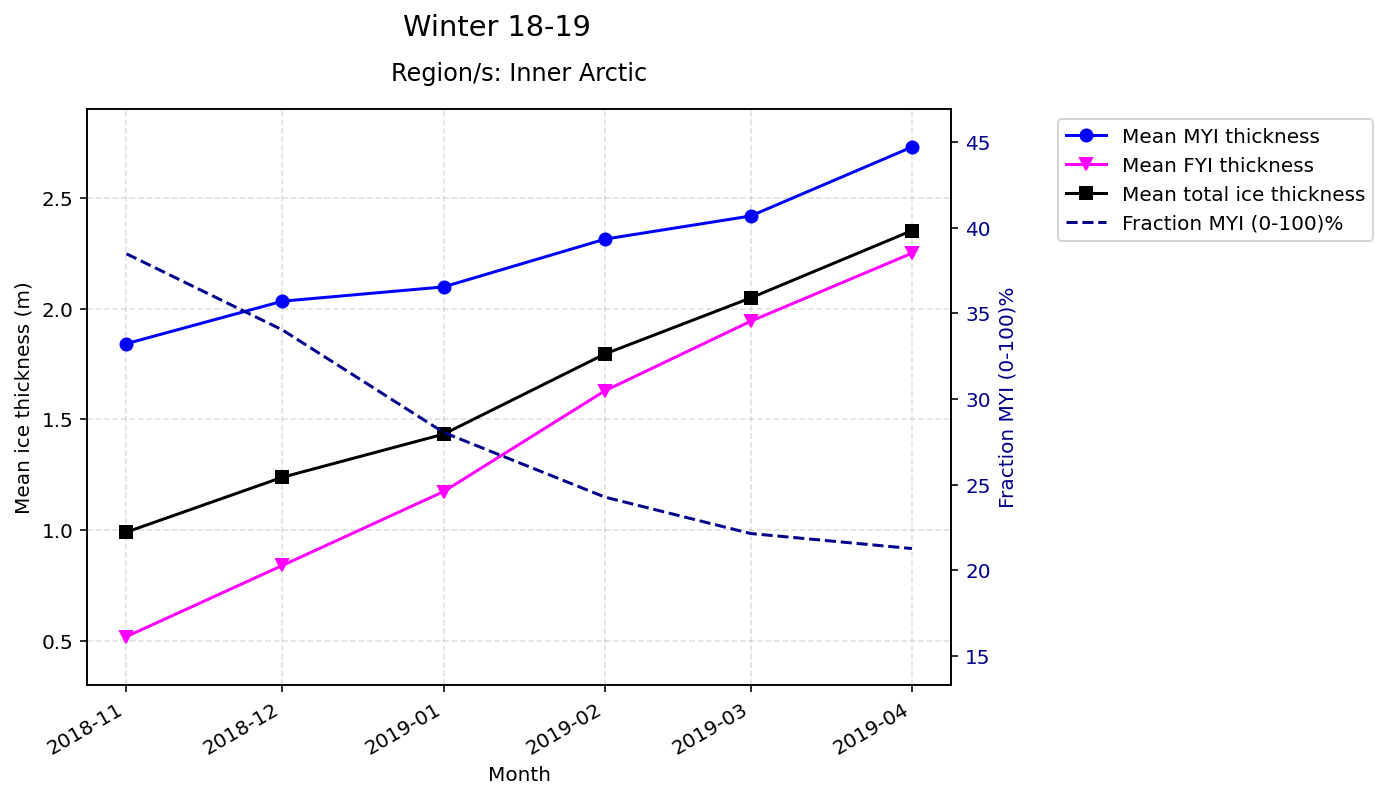

In [13]:
winter = utils.getWinterDateRange(2018, 2019)
datasetWinter = dataset.sel(time = winter)
plotThicknessAndFrac(datasetWinter, title = 'Winter 18-19', ylim = ylimThickness, ylimFrac = ylimFrac)

### Plot data for winter 2019-2020

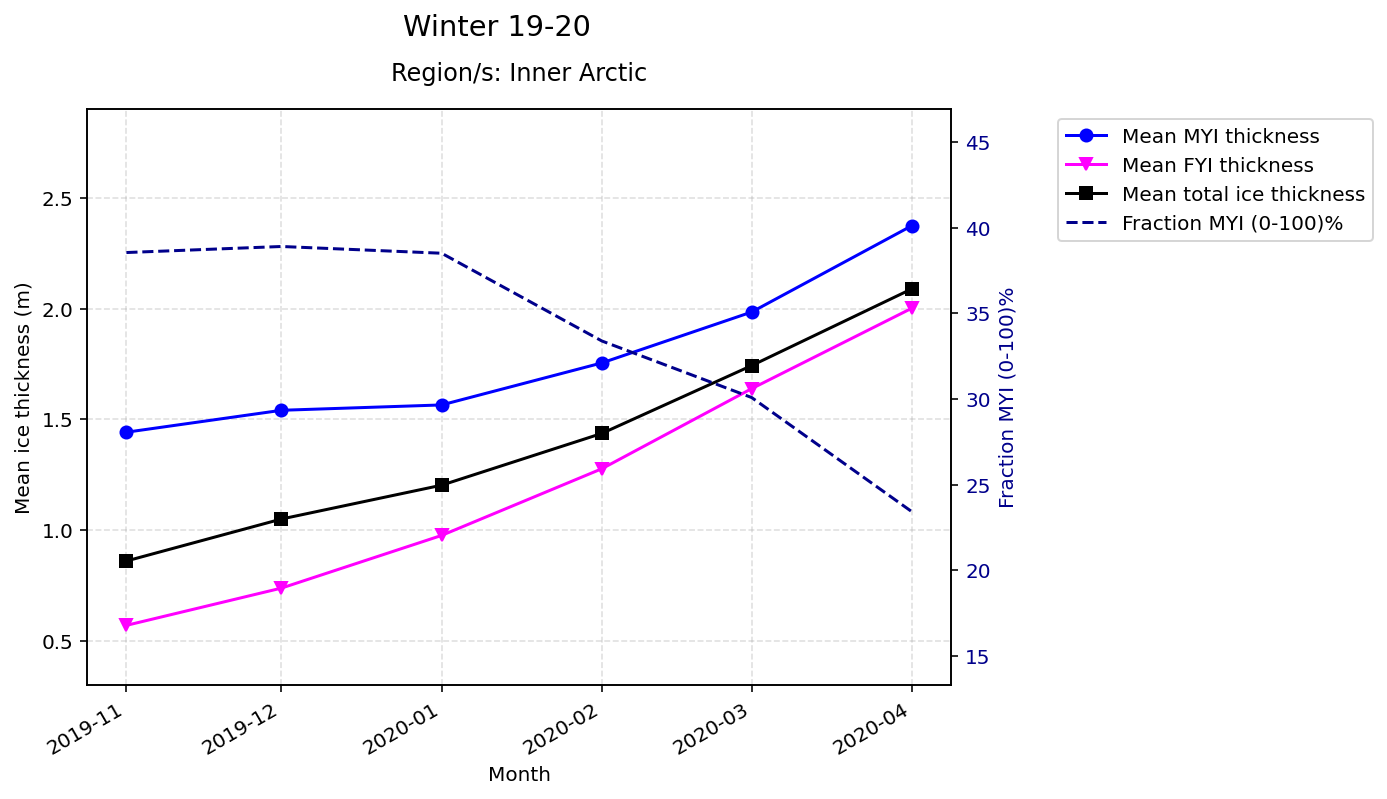

In [14]:
winter = utils.getWinterDateRange(2019, 2020)
datasetWinter = dataset.sel(time = winter)
plotThicknessAndFrac(datasetWinter, title = 'Winter 19-20', ylim = ylimThickness, ylimFrac = ylimFrac)